In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
from matplotlib.lines import Line2D
print(Line2D.markers)

{'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', 'none': 'nothing', ' ': 'nothing', '': 'nothing'}


In [15]:
def substring_before_bracket(str):
    return str.split("(")[0]

In [16]:
colours_map = { 'FixedThreshold' : "blue",
                 'IndicatorBased' : "purple",
                 'NullDecisionNode' : "ignore",
                 'RandomDecisionNode' : "ignore",
                 'SimAnnealingMulti' : "green",
                 'SimAnnealingSingle' : "ignore",
                 'default' : "black" 
                }

shapes_map = { 'FixedThreshold' : ".",
               'IndicatorBased' : "^",
               'NullDecisionNode' : "ignore",
               'RandomDecisionNode' : "ignore",
               'SimAnnealingMulti' : "1",
               'SimAnnealingSingle' : "2",
               'default' : "black" 
             }

rename_map = {
    'IndicatorBased' : 'Diversity-Driven',
    'SimAnnealingMulti' : 'SA',
}

# Use the shape map
# TODO: add tolerance to the indicator based node - allow it to add some weaker predictions with a certain probability
# first try the fixed values e.g. 0.99, 0.95, 0.9 - how does this impact the performance
# it could change over the run as in simulated annealing
# how can the history be used in order to calibrate the tolerance of the indicator based

In [17]:
def plot_decision_node_results(filename, plot_type="front_proportion"):
    df = pd.read_csv(filename)
    df["tests_performed_ratio"] = df["tests_chosen_count"] / df["all_tests_count"]
    df["tests_saved_ratio"] = 1 - df["tests_performed_ratio"]
    df["front_proportion"] = df["front_from_decision_node_size"] / df["front_all_tests_size"]
    # Need to classify them by the type - before the bracket

    min_proportion_of_tests = max(df["front_all_tests_size"] / df["all_tests_count"])
    
    df["decision_node_type"] = df["decision_node"].map(substring_before_bracket)

    all_decision_node_types = sorted(set(df["decision_node_type"]))
    for dn_type in all_decision_node_types: 
        subset = df[df['decision_node_type'] == dn_type]
        if dn_type in colours_map:
            col = colours_map[dn_type]
            shape = shapes_map[dn_type]
        else:
            col = colours_map["default"]
        if col != "ignore":

            series_name = dn_type
            if dn_type in rename_map:
                series_name = rename_map[dn_type]
            
            if plot_type == "proportion_tests_included":
                plt.scatter(subset["tests_performed_ratio"], subset["proportion_of_ref_tests_included"], c=col, label=series_name, marker=shape)
                plt.xlim(0,1)
                plt.plot([min_proportion_of_tests, min_proportion_of_tests], [0.95, 1.05], c="black", linestyle="dashed")
                plt.plot([min_proportion_of_tests - 0.03, min_proportion_of_tests+0.03], [1.0, 1.0], c="black", linestyle="dashed")
            elif plot_type == "hypervolume_igd":
                plt.scatter(subset["decision_node_hypervolume"], subset["decision_node_igd"], c=col, label=series_name, marker=shape)
            elif plot_type == "hypervolume_per_tests_chosen":
                plt.scatter(subset["tests_performed_ratio"], subset["decision_node_hypervolume"], c=col, label=series_name, marker=shape)
    
    if plot_type=="proportion_tests_included":
        plt.xlabel('Proportion of tests performed')
        plt.ylabel('Proportion of tests on front also in reference front')
        plt.title('Front quality for various levels of tests performed')
        plt.legend()
        plt.savefig(filename + "_proportion_plot.pdf")
        plt.show()
        
    elif plot_type=="hypervolume_igd":
        plt.xlabel('Hypervolume')
        plt.ylabel('IGD')
        plt.title('Hypervolume vs IGD')
        plt.legend()
        plt.savefig(filename + "_hypervolume_igd_plot.pdf")
        plt.show()
        
    elif plot_type=="hypervolume_per_tests_chosen":
        plt.xlabel('Proportion of tests performed')
        plt.ylabel('Hypervolume')
        plt.title('Proportion of tests chosen vs hypervolume of generated front')
        plt.legend()
        plt.show()

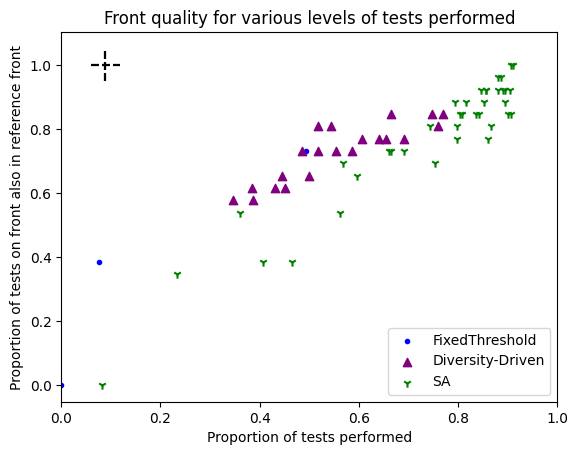

In [18]:
plot_decision_node_results("eterry/eterry-choice1-decisions.csv", plot_type="proportion_tests_included")
#Add the theoretical maximum point - 26/292 proportion of tests, 100% on the front

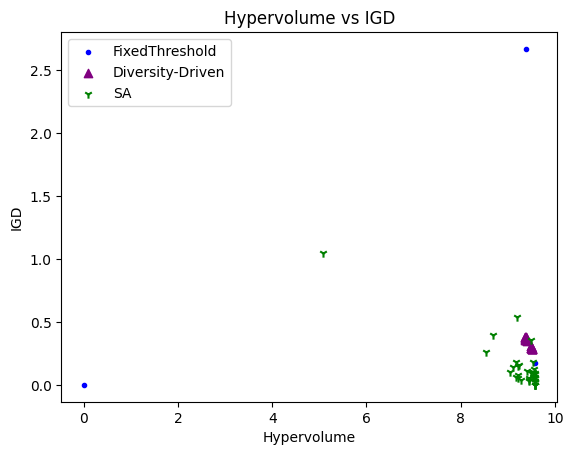

In [19]:
plot_decision_node_results("eterry/eterry-choice1-decisions.csv", plot_type="hypervolume_igd")

In [20]:
# Plot Percentage of tests performed vs hypervolume
def plot_tests_versus_hypervolume(filename):
    df = pd.read_csv(filename)
    tests_performed_ratio = df["tests_chosen_count"] / df["all_tests_count"]
    plt.scatter(tests_performed_ratio, df["decision_node_hypervolume"])


In [21]:
def find_any_greater_hvs(filename):
    df = pd.read_csv(filename)
    all_tests_hv = df["all_tests_hypervolume"]
    dn_hv = df["decision_node_hypervolume"]
    greater = df[dn_hv > all_tests_hv]
    greater_count = len(greater)
    print(f"Count of decision nodes with greater HV than all tests: {greater_count}")
    if greater_count > 0:
        return greater
    else:
        return None

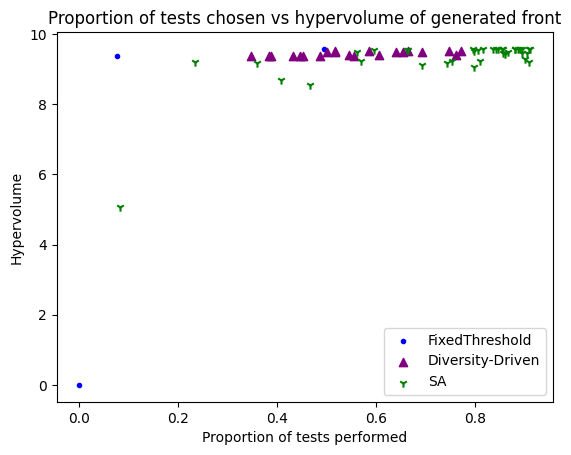

In [22]:
plt.clf
plot_decision_node_results("eterry/eterry-choice1-decisions.csv", plot_type="hypervolume_per_tests_chosen")
# 

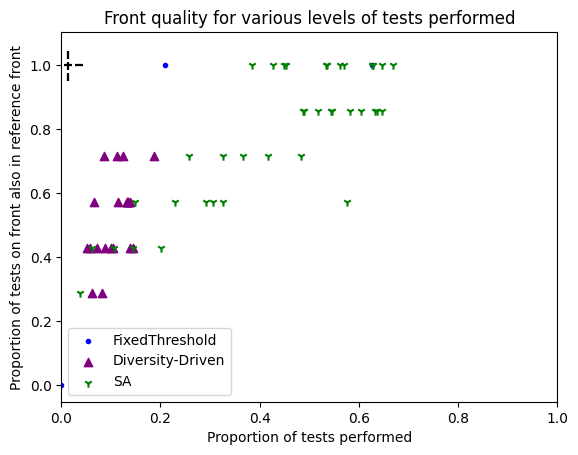

In [23]:
plot_decision_node_results("multiturtlebot/multiturtlebot-choice1-decisions.csv", plot_type="proportion_tests_included")

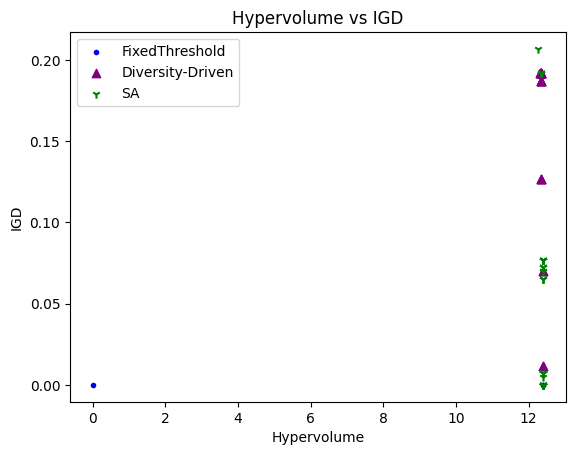

In [24]:
plot_decision_node_results("multiturtlebot/multiturtlebot-choice1-decisions.csv", plot_type="hypervolume_igd")

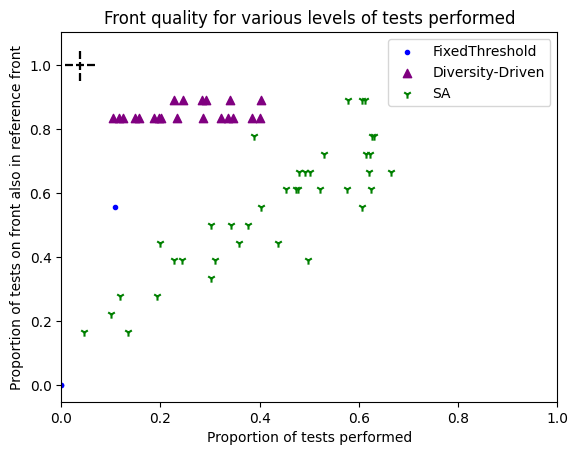

In [25]:
# This run had min_improvment_factor at 0 and range of execute_lower_prob
plot_decision_node_results("mycobot/mycobot-choice1-decisions.csv", plot_type="proportion_tests_included")

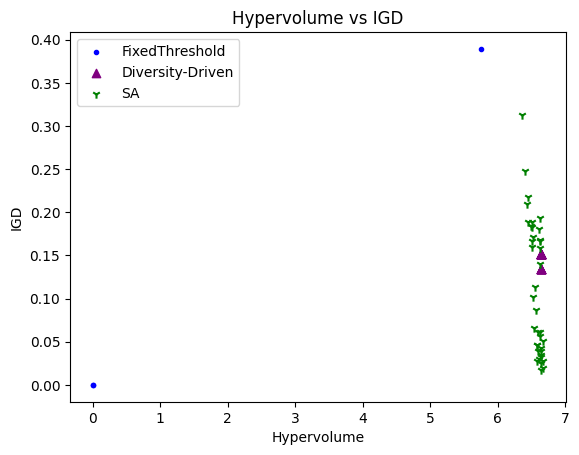

In [26]:
# This run had min_improvment_factor at 0 and range of execute_lower_prob
plot_decision_node_results("mycobot/mycobot-choice1-decisions.csv", plot_type="hypervolume_igd")

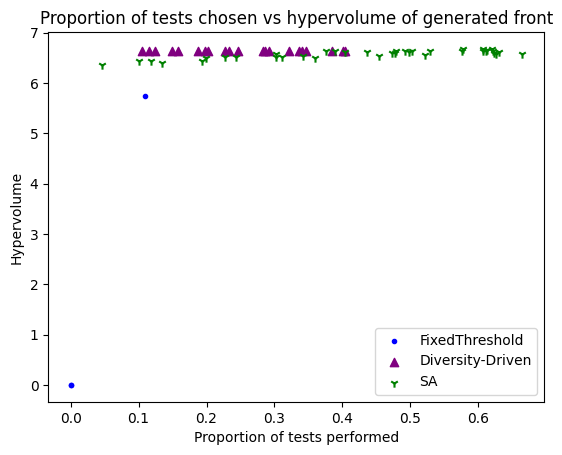

In [52]:
plt.clf
plot_decision_node_results("mycobot/mycobot-choice1-decisions.csv", plot_type="hypervolume_per_tests_chosen")

In [27]:
find_any_greater_hvs("eterry/eterry-choice1-decisions.csv")

Count of decision nodes with greater HV than all tests: 0


In [28]:
find_any_greater_hvs("mycobot/mycobot-choice1-decisions.csv")

Count of decision nodes with greater HV than all tests: 0


In [29]:
find_any_greater_hvs("multiturtlebot/multiturtlebot-choice1-decisions.csv")

Count of decision nodes with greater HV than all tests: 0


In [30]:
def check_all():
    find_any_greater_hvs("eterry/eterry-choice1-decisions.csv")
    find_any_greater_hvs("mycobot/mycobot-choice1-decisions.csv")
    find_any_greater_hvs("multiturtlebot/multiturtlebot-choice1-decisions.csv")

check_all()

Count of decision nodes with greater HV than all tests: 0
Count of decision nodes with greater HV than all tests: 0
Count of decision nodes with greater HV than all tests: 0


Count of decision nodes with greater HV than all tests: 0
Count of decision nodes with greater HV than all tests: 0
Count of decision nodes with greater HV than all tests: 0


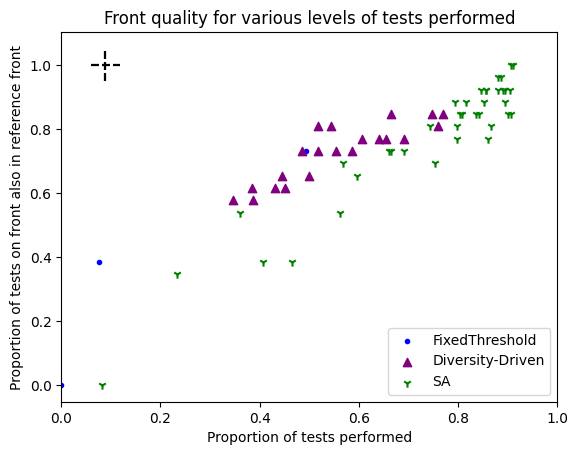

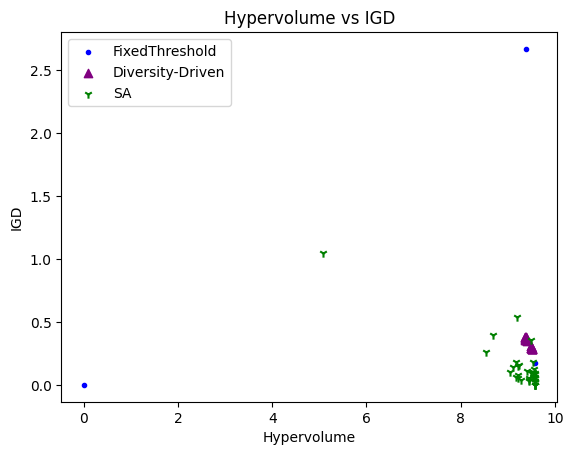

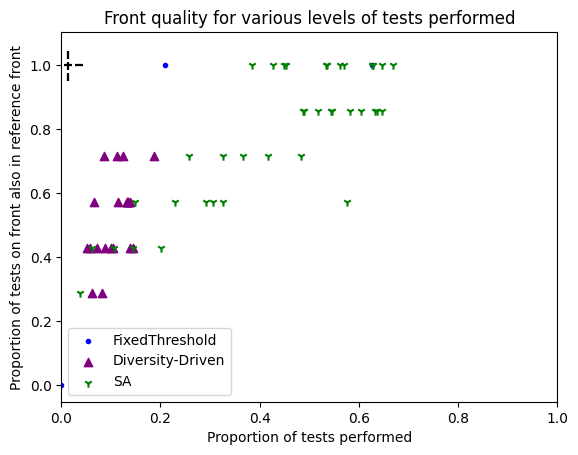

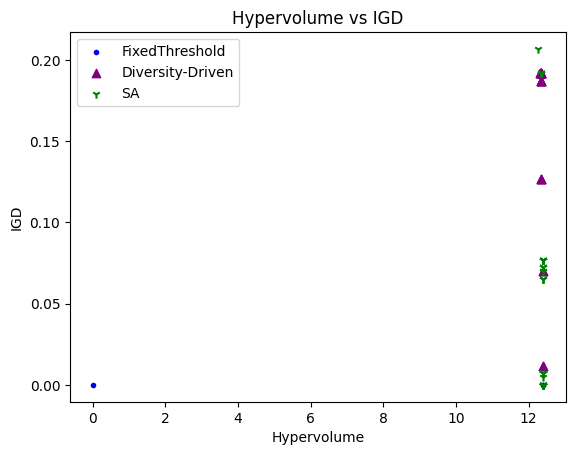

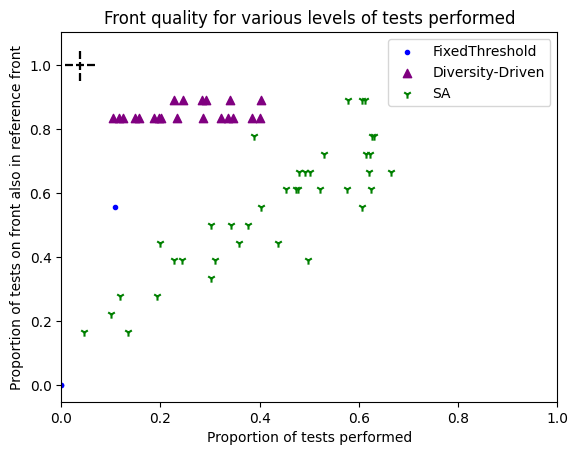

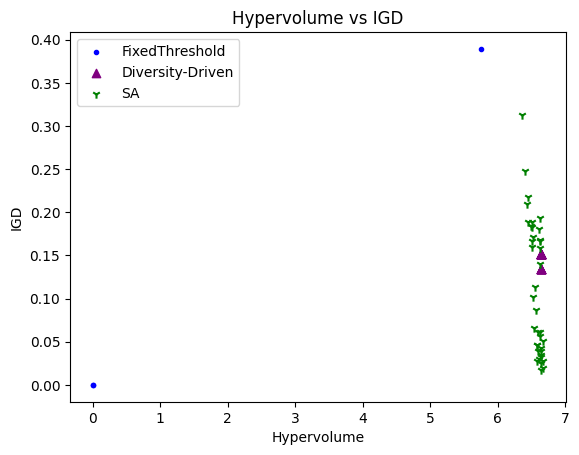

In [31]:
def update_all_graphs():
    check_all()
    plot_decision_node_results("eterry/eterry-choice1-decisions.csv", plot_type="proportion_tests_included")
    plot_decision_node_results("eterry/eterry-choice1-decisions.csv", plot_type="hypervolume_igd")
    
    plot_decision_node_results("multiturtlebot/multiturtlebot-choice1-decisions.csv", plot_type="proportion_tests_included")
    plot_decision_node_results("multiturtlebot/multiturtlebot-choice1-decisions.csv", plot_type="hypervolume_igd")
    
    plot_decision_node_results("mycobot/mycobot-choice1-decisions.csv", plot_type="proportion_tests_included")
    plot_decision_node_results("mycobot/mycobot-choice1-decisions.csv", plot_type="hypervolume_igd")

update_all_graphs()